In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder

sns.set_theme(style="darkgrid")

In [48]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [49]:
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt'])

<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\woomi\AppData\Local\Temp\ipykernel_38744\1593314387.py:2: SyntaxWarning: invalid escape sequence '\('
  regex = "\(.*\)|\s-\s.*"
100%|██████████| 5463/5463 [00:00<00:00, 36770.35it/s]


In [50]:
train_df['apt'].value_counts()[:20]

apt
현대        17716
한신        10135
삼성         6771
대우         6390
신동아        6386
두산         5801
우성         5781
주공2        5669
삼성래미안      5483
벽산         4651
대림         4582
동원로얄듀크     4430
경남         4030
삼환         3896
극동         3771
삼익         3583
롯데캐슬       3570
쌍용         3409
코오롱        3320
한양         3231
Name: count, dtype: int64

In [51]:
print(train_df['apt'].nunique(), test_df['apt'].nunique())


9374 3273


In [52]:
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

변환전
 apt
상지리츠빌카일룸2차     530000.000000
트라움하우스3        490000.000000
아펠바움           465860.500000
상지리츠빌카일룸3차     427125.000000
삼성동상지리츠빌카일룸    418992.666667
Name: transaction_real_price, dtype: float64


In [54]:
test_start = train_df.loc[train_df['transaction_year_month'] == 201701, 'transaction_year_month'].index[0]

In [55]:
print(train_df['year_of_completion'].min())
print(test_df['year_of_completion'].min())

# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', train_df['year_of_completion'].unique()[:5])
train_df['year_of_completion'] = train_df['year_of_completion'] - train_df['year_of_completion'].min()
test_df['year_of_completion'] = test_df['year_of_completion'] - test_df['year_of_completion'].min()
print('변환후\n', train_df['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train_df['transaction_year_month'].unique()[:5])
print('test 변환전\n', test_df['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train_df['transaction_year_month'] = le.fit_transform(train_df['transaction_year_month'])
# test는 다음과 같이 처리
test_df['transaction_year_month'] = test_df['transaction_year_month'] - test_df['transaction_year_month'].min() + train_df.at[test_start, 'transaction_year_month']
print('train 변환후\n', train_df['transaction_year_month'].unique()[:5])
print('test 변환후\n', test_df['transaction_year_month'].unique()[:5])

# 필요없는 열 제거
train_df = train_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)
test_df = test_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

1961
1961
변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
test 변환전
 [201711 201708 201710 201707 201712]
train 변환후
 [0 1 2 3 4]
test 변환후
 [118 115 117 114 119]


In [10]:
seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)

seoul_set = set(test_df.loc[test_df['city']=='서울특별시', 'dong'])
busan_set = set(test_df.loc[test_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)

{'송정동', '사직동', '부암동', '중동'}
{'송정동', '사직동', '부암동', '중동'}


In [11]:
for d in same_dong:
    train_df.loc[(train_df['city']=='서울특별시') & (train_df['dong']==d), 'dong'] = '서울' + d
    train_df.loc[(train_df['city']=='부산광역시') & (train_df['dong']==d), 'dong'] = '부산' + d
    test_df.loc[(test_df['city']=='서울특별시') & (test_df['dong']==d), 'dong'] = '서울' + d
    test_df.loc[(test_df['city']=='부산광역시') & (test_df['dong']==d), 'dong'] = '부산' + d


seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)

set()


In [12]:
# dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
# for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
#     train_df.loc[train_df['dong'] == d, 'dong'] = i
#     test_df.loc[test_df['dong'] == d, 'dong'] = i
train_df.head()

100%|██████████| 477/477 [00:27<00:00, 17.66it/s]


,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
0,0,7622,서울특별시,138,신현,84.82,41,0,2,37500
1,1,5399,서울특별시,65,사직파크맨션,99.17,12,0,6,20000
2,2,3578,서울특별시,65,두레엘리시안,84.74,46,0,6,38500
3,3,10957,서울특별시,13,파크팰리스,146.39,42,0,15,118000
4,4,10639,서울특별시,13,킹스매너,194.43,43,0,3,120000


In [13]:
# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', train_df['floor'].values[:5])
train_df['floor'] = train_df['floor'].map(lambda x: x+4)
test_df['floor'] = test_df['floor'].map(lambda x: x+1)
print('변환후\n', train_df['floor'].values[:5])

변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


<Figure size 640x480 with 0 Axes>

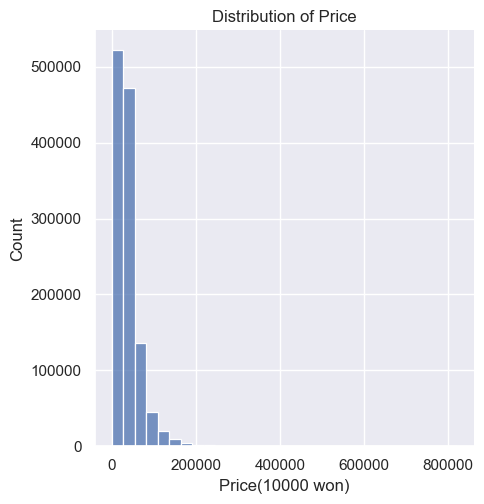

In [14]:
# train price
plt.figure()
sns.displot(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

In [15]:
# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price'] = np.log1p(train_df['transaction_real_price'])
real_price = train_df['transaction_real_price'] # 원래 가격
train_df.drop('transaction_real_price', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,log_price
0,0,7622,서울특별시,138,신현,84.82,41,0,6,10.532123


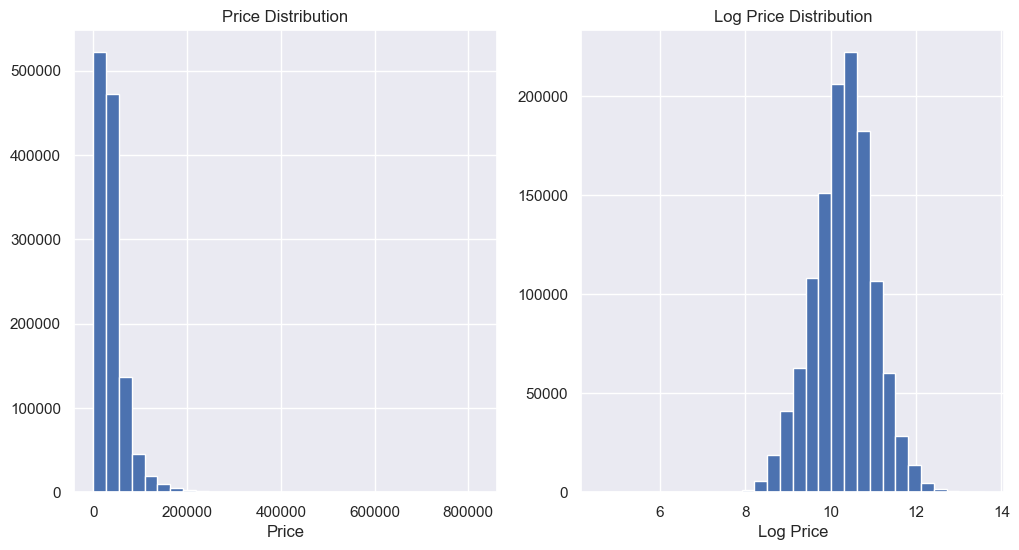

In [16]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train_df['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

<Figure size 640x480 with 0 Axes>

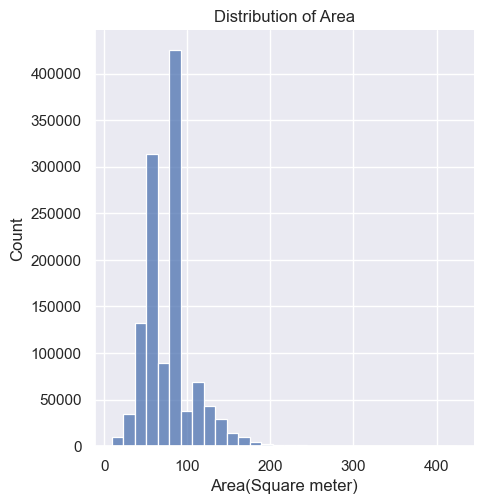

In [17]:
# train area
plt.figure()
sns.displot(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [18]:
# 면적 로그 변환 후 원래 면적 따로 저장
train_df['log_area'] = np.log1p(train_df['exclusive_use_area'])
test_df['log_area'] = np.log1p(test_df['exclusive_use_area'])
area = train_df['exclusive_use_area'] # 원래 가격
train_df.drop('exclusive_use_area', axis=1, inplace=True)
test_df.drop('exclusive_use_area', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
0,0,7622,서울특별시,138,신현,41,0,6,10.532123,4.452252


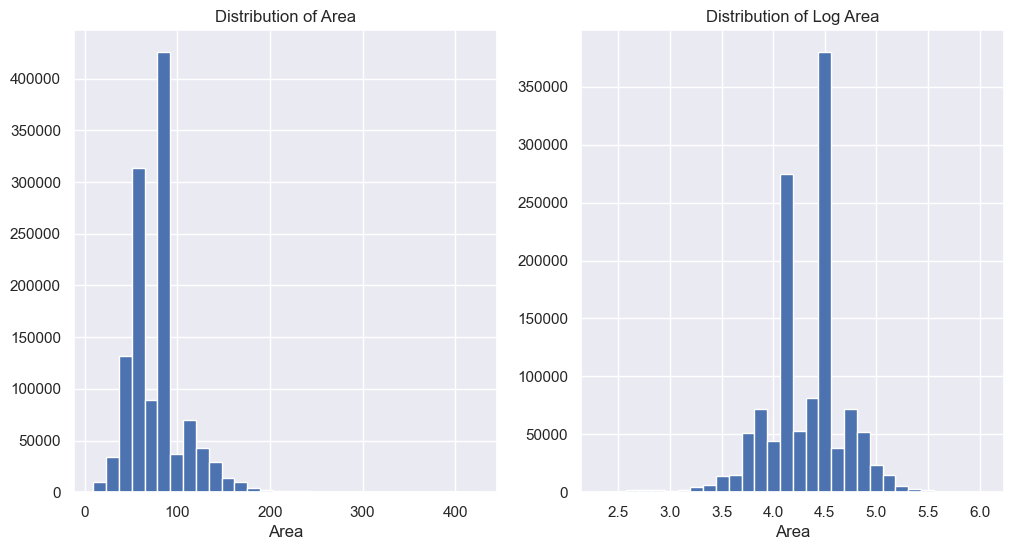

In [19]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(train_df['log_area'], bins=30)
ax2.set_title('Distribution of Log Area')
ax2.set_xlabel('Area')

plt.show()

In [20]:
drop_col = ['transaction_id', 'apartment_id', 'apt_counts', 'transformed']

train_df['city'] = train_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test_df['city'] = test_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)

In [21]:
# train_df.drop(drop_col, axis=1, inplace=True)
# test_df.drop(drop_col, axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
0,0,7622,1,138,신현,41,0,6,10.532123,4.452252


In [22]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 학습 데이터와 테스트 데이터를 합침
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# 숫자와 문자열이 섞여 있는 경우 숫자를 문자열로 변환
combined_df['dong'] = combined_df['dong'].astype(str)
combined_df['apt'] = combined_df['apt'].astype(str)

# LabelEncoder를 사용하여 'dong'과 'apt' 열을 숫자로 변환
label_encoder_dong = LabelEncoder()
label_encoder_apt = LabelEncoder()

# 'dong' 열 인코딩
combined_df['dong'] = label_encoder_dong.fit_transform(combined_df['dong'])

# 'apt' 열 인코딩
combined_df['apt'] = label_encoder_apt.fit_transform(combined_df['apt'])

# 다시 학습 데이터와 테스트 데이터로 분리
train_df = combined_df.iloc[:len(train_df)]
test_df = combined_df.iloc[len(train_df):]

# 데이터 정보 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  int64  
 3   dong                    1216553 non-null  int32  
 4   apt                     1216553 non-null  int32  
 5   year_of_completion      1216553 non-null  int64  
 6   transaction_year_month  1216553 non-null  int64  
 7   floor                   1216553 non-null  int64  
 8   log_price               1216553 non-null  float64
 9   log_area                1216553 non-null  float64
dtypes: float64(2), int32(2), int64(6)
memory usage: 83.5 MB


In [23]:
test_df.head()

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
1216553,1145756,10453,1,424,7824,41,118,3,NaN,3.598681
1216554,1198704,989,0,354,519,16,115,3,NaN,4.244487
1216555,1222384,8597,0,345,6441,28,117,3,NaN,4.297829
1216556,1179897,11086,1,455,8317,43,114,11,NaN,4.723309
1216557,1223091,2121,0,352,1393,53,119,22,NaN,4.792809


# model

In [24]:
train_X, train_y = train_df.drop('log_price', axis=1), train_df['log_price']
print(train_X.shape, train_y.shape)

(1216553, 9) (1216553,)


In [25]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred)
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [26]:
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [27]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 9) (973242,) (243311, 9) (243311,)


In [28]:
h_train_X.head()


,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_area
0,0,7622,1,44,5632,41,0,6,4.452252
1,1,5399,1,439,3923,12,0,10,4.606869
2,2,3578,1,439,2443,46,0,10,4.451319
3,3,10957,1,35,8218,42,0,19,4.993082
4,4,10639,1,35,7980,43,0,7,5.275202


In [29]:
from optuna.samplers import TPESampler
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgb

sampler = TPESampler(seed=10)

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1e-2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1, log=True),
    }

    model = lgb.LGBMRegressor(**param)

    # 콜백을 사용하여 LightGBM의 학습 로그를 제어
    lgb_model = model.fit(h_train_X, h_train_y,
                          eval_set=[(h_valid_X, h_valid_y)],
                          callbacks=[early_stopping(25), log_evaluation(0)])  # 학습 중 출력 최소화

    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse

# Optuna 최적화 수행
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

# 최종 best_trial 출력
trial = study_lgb.best_trial
print(f"Best Trial: RMSE = {trial.value}")
print("Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2024-10-04 01:56:42,969] A new study created in memory with name: no-name-6018d410-fbe6-4328-af6d-d71af4d876b7


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1938]	valid_0's rmse: 0.737137


[I 2024-10-04 01:57:16,137] Trial 0 finished with value: 0.737136556667795 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.737136556667795.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2306]	valid_0's rmse: 0.736957


[I 2024-10-04 01:57:48,693] Trial 1 finished with value: 0.7369571632862124 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.7369571632862124.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds


[I 2024-10-04 01:57:50,522] Trial 2 finished with value: 0.5064993704565856 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.5064993704565856.


Did not meet early stopping. Best iteration is:
[111]	valid_0's rmse: 0.506499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[946]	valid_0's rmse: 0.638109


[I 2024-10-04 01:58:04,522] Trial 3 finished with value: 0.638109175842026 and parameters: {'max_depth': 10, 'learning_rate': 0.00021405821746591817, 'n_estimators': 946, 'min_child_samples': 93, 'subsample': 0.7698715745641292}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1183]	valid_0's rmse: 0.737104


[I 2024-10-04 01:58:22,497] Trial 4 finished with value: 0.7371039863864338 and parameters: {'max_depth': 10, 'learning_rate': 7.128863277996207e-08, 'n_estimators': 1183, 'min_child_samples': 69, 'subsample': 0.5996296351455978}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1588]	valid_0's rmse: 0.694446


[I 2024-10-04 01:58:45,835] Trial 5 finished with value: 0.694446370971633 and parameters: {'max_depth': 8, 'learning_rate': 5.08864167992051e-05, 'n_estimators': 1588, 'min_child_samples': 67, 'subsample': 0.6938050197112922}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2735]	valid_0's rmse: 0.717102


[I 2024-10-04 01:59:25,261] Trial 6 finished with value: 0.7171018326281121 and parameters: {'max_depth': 13, 'learning_rate': 1.3485992516968212e-05, 'n_estimators': 2735, 'min_child_samples': 35, 'subsample': 0.4345676420333751}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2504]	valid_0's rmse: 0.737084


[I 2024-10-04 02:00:00,510] Trial 7 finished with value: 0.7370836187323091 and parameters: {'max_depth': 6, 'learning_rate': 4.8295444901938926e-08, 'n_estimators': 2504, 'min_child_samples': 9, 'subsample': 0.7100430887666348}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[677]	valid_0's rmse: 0.513637


[I 2024-10-04 02:00:10,545] Trial 8 finished with value: 0.513637296756113 and parameters: {'max_depth': 10, 'learning_rate': 0.0008236106883720722, 'n_estimators': 677, 'min_child_samples': 87, 'subsample': 0.5520731753100153}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2664]	valid_0's rmse: 0.736267


[I 2024-10-04 02:00:48,992] Trial 9 finished with value: 0.7362670198397306 and parameters: {'max_depth': 12, 'learning_rate': 5.967195151630884e-07, 'n_estimators': 2664, 'min_child_samples': 36, 'subsample': 0.46529289303849874}. Best is trial 2 with value: 0.5064993704565856.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2024-10-04 02:00:50,391] Trial 10 finished with value: 0.45290476288796855 and parameters: {'max_depth': 3, 'learning_rate': 0.007287079614451884, 'n_estimators': 125, 'min_child_samples': 50, 'subsample': 0.9370978022952945}. Best is trial 10 with value: 0.45290476288796855.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[125]	valid_0's rmse: 0.452905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 25 rounds
[Li

[I 2024-10-04 02:00:51,820] Trial 11 finished with value: 0.4104348944089293 and parameters: {'max_depth': 3, 'learning_rate': 0.009781360056777894, 'n_estimators': 134, 'min_child_samples': 50, 'subsample': 0.9778082962377218}. Best is trial 11 with value: 0.4104348944089293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[134]	valid_0's rmse: 0.410435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973

[I 2024-10-04 02:00:53,386] Trial 12 finished with value: 0.4199956053888356 and parameters: {'max_depth': 3, 'learning_rate': 0.007773589322284729, 'n_estimators': 151, 'min_child_samples': 46, 'subsample': 0.9989436234186677}. Best is trial 11 with value: 0.4104348944089293.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2024-10-04 02:00:58,614] Trial 13 finished with value: 0.5596554894496987 and parameters: {'max_depth': 3, 'learning_rate': 0.0007774822178201122, 'n_estimators': 544, 'min_child_samples': 49, 'subsample': 0.9537507201053227}. Best is trial 11 with value: 0.4104348944089293.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[540]	valid_0's rmse: 0.73674


[I 2024-10-04 02:01:06,525] Trial 14 finished with value: 0.7367396949583596 and parameters: {'max_depth': 15, 'learning_rate': 1.368831194255526e-06, 'n_estimators': 540, 'min_child_samples': 34, 'subsample': 0.9796365205471653}. Best is trial 11 with value: 0.4104348944089293.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1196]	valid_0's rmse: 0.347576


[I 2024-10-04 02:01:22,473] Trial 15 finished with value: 0.347575909470804 and parameters: {'max_depth': 5, 'learning_rate': 0.0014612244189578791, 'n_estimators': 1196, 'min_child_samples': 59, 'subsample': 0.8379610960606707}. Best is trial 15 with value: 0.347575909470804.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1379]	valid_0's rmse: 0.474331


[I 2024-10-04 02:01:42,026] Trial 16 finished with value: 0.474330665160249 and parameters: {'max_depth': 6, 'learning_rate': 0.0005201620776173716, 'n_estimators': 1379, 'min_child_samples': 60, 'subsample': 0.8387686631458968}. Best is trial 15 with value: 0.347575909470804.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1867]	valid_0's rmse: 0.673112


[I 2024-10-04 02:02:07,040] Trial 17 finished with value: 0.6731122925594403 and parameters: {'max_depth': 5, 'learning_rate': 6.790663195577434e-05, 'n_estimators': 1867, 'min_child_samples': 79, 'subsample': 0.8454918854124668}. Best is trial 15 with value: 0.347575909470804.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[964]	valid_0's rmse: 0.304335


[I 2024-10-04 02:02:20,841] Trial 18 finished with value: 0.30433525282895413 and parameters: {'max_depth': 8, 'learning_rate': 0.0034512962964751456, 'n_estimators': 964, 'min_child_samples': 23, 'subsample': 0.7551738281217693}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[955]	valid_0's rmse: 0.366719


[I 2024-10-04 02:02:34,573] Trial 19 finished with value: 0.3667193466747527 and parameters: {'max_depth': 7, 'learning_rate': 0.0016151271893630687, 'n_estimators': 955, 'min_child_samples': 11, 'subsample': 0.7248193949654819}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1686]	valid_0's rmse: 0.731441


[I 2024-10-04 02:02:58,758] Trial 20 finished with value: 0.7314409793084496 and parameters: {'max_depth': 8, 'learning_rate': 6.125424702987981e-06, 'n_estimators': 1686, 'min_child_samples': 22, 'subsample': 0.5534573772272844}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[949]	valid_0's rmse: 0.359583


[I 2024-10-04 02:03:12,348] Trial 21 finished with value: 0.35958290866406806 and parameters: {'max_depth': 7, 'learning_rate': 0.001724060926238623, 'n_estimators': 949, 'min_child_samples': 5, 'subsample': 0.7401098782588889}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1159]	valid_0's rmse: 0.31422


[I 2024-10-04 02:03:28,973] Trial 22 finished with value: 0.3142203529752364 and parameters: {'max_depth': 8, 'learning_rate': 0.002354928842871457, 'n_estimators': 1159, 'min_child_samples': 5, 'subsample': 0.7917356137383065}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1276]	valid_0's rmse: 0.65433


[I 2024-10-04 02:03:47,326] Trial 23 finished with value: 0.6543298683649804 and parameters: {'max_depth': 8, 'learning_rate': 0.00012967707814410406, 'n_estimators': 1276, 'min_child_samples': 18, 'subsample': 0.8092642887308649}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1089]	valid_0's rmse: 0.323394


[I 2024-10-04 02:04:01,545] Trial 24 finished with value: 0.3233938526430842 and parameters: {'max_depth': 5, 'learning_rate': 0.002205304414520416, 'n_estimators': 1089, 'min_child_samples': 26, 'subsample': 0.6752964416666491}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[745]	valid_0's rmse: 0.609676


[I 2024-10-04 02:04:12,322] Trial 25 finished with value: 0.6096762698195809 and parameters: {'max_depth': 9, 'learning_rate': 0.000363309193203308, 'n_estimators': 745, 'min_child_samples': 27, 'subsample': 0.6739751780291228}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1468]	valid_0's rmse: 0.721515


[I 2024-10-04 02:04:32,750] Trial 26 finished with value: 0.721515224860499 and parameters: {'max_depth': 6, 'learning_rate': 1.9507033427198717e-05, 'n_estimators': 1468, 'min_child_samples': 16, 'subsample': 0.6414092338025281}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1064]	valid_0's rmse: 0.309472


[I 2024-10-04 02:04:47,961] Trial 27 finished with value: 0.30947149985546696 and parameters: {'max_depth': 9, 'learning_rate': 0.0027594391216248524, 'n_estimators': 1064, 'min_child_samples': 26, 'subsample': 0.5618086936668583}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[361]	valid_0's rmse: 0.37069


[I 2024-10-04 02:04:53,283] Trial 28 finished with value: 0.37069037473408745 and parameters: {'max_depth': 9, 'learning_rate': 0.004145217470794168, 'n_estimators': 361, 'min_child_samples': 11, 'subsample': 0.5729452107775886}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2117]	valid_0's rmse: 0.532905


[I 2024-10-04 02:05:23,576] Trial 29 finished with value: 0.5329047354214086 and parameters: {'max_depth': 9, 'learning_rate': 0.0002313500778893689, 'n_estimators': 2117, 'min_child_samples': 40, 'subsample': 0.4780697087371365}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1762]	valid_0's rmse: 0.733794


[I 2024-10-04 02:05:48,843] Trial 30 finished with value: 0.7337943674396578 and parameters: {'max_depth': 11, 'learning_rate': 3.43593828203132e-06, 'n_estimators': 1762, 'min_child_samples': 28, 'subsample': 0.6189750085150246}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1059]	valid_0's rmse: 0.314226


[I 2024-10-04 02:06:04,045] Trial 31 finished with value: 0.3142255298190293 and parameters: {'max_depth': 7, 'learning_rate': 0.0025991521066344603, 'n_estimators': 1059, 'min_child_samples': 27, 'subsample': 0.5177433545349365}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[793]	valid_0's rmse: 0.327963


[I 2024-10-04 02:06:15,634] Trial 32 finished with value: 0.3279627298886103 and parameters: {'max_depth': 7, 'learning_rate': 0.002892534205805447, 'n_estimators': 793, 'min_child_samples': 15, 'subsample': 0.49767449986893453}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1053]	valid_0's rmse: 0.422638


[I 2024-10-04 02:06:30,791] Trial 33 finished with value: 0.4226376345820221 and parameters: {'max_depth': 8, 'learning_rate': 0.0009597873611230688, 'n_estimators': 1053, 'min_child_samples': 41, 'subsample': 0.5247492222324364}. Best is trial 18 with value: 0.30433525282895413.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1161]	valid_0's rmse: 0.297969


[I 2024-10-04 02:06:47,759] Trial 34 finished with value: 0.29796912766343986 and parameters: {'max_depth': 11, 'learning_rate': 0.0037632968348191684, 'n_estimators': 1417, 'min_child_samples': 5, 'subsample': 0.4111484383347534}. Best is trial 34 with value: 0.29796912766343986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1557]	valid_0's rmse: 0.295534


[I 2024-10-04 02:07:10,584] Trial 35 finished with value: 0.29553408981802887 and parameters: {'max_depth': 11, 'learning_rate': 0.0036777019548282176, 'n_estimators': 2985, 'min_child_samples': 5, 'subsample': 0.7761426707012951}. Best is trial 35 with value: 0.29553408981802887.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2175]	valid_0's rmse: 0.616609


[I 2024-10-04 02:07:41,984] Trial 36 finished with value: 0.6166086937138512 and parameters: {'max_depth': 11, 'learning_rate': 0.00011667404859705454, 'n_estimators': 2175, 'min_child_samples': 19, 'subsample': 0.43549047372288546}. Best is trial 35 with value: 0.29553408981802887.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1532]	valid_0's rmse: 0.737142


[I 2024-10-04 02:08:03,916] Trial 37 finished with value: 0.737142186742543 and parameters: {'max_depth': 13, 'learning_rate': 1.0247621894239389e-08, 'n_estimators': 1532, 'min_child_samples': 12, 'subsample': 0.4124735401701441}. Best is trial 35 with value: 0.29553408981802887.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1352]	valid_0's rmse: 0.713878


[I 2024-10-04 02:08:23,391] Trial 38 finished with value: 0.7138782723025565 and parameters: {'max_depth': 12, 'learning_rate': 3.1774767809458236e-05, 'n_estimators': 1352, 'min_child_samples': 22, 'subsample': 0.8800043890825744}. Best is trial 35 with value: 0.29553408981802887.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2819]	valid_0's rmse: 0.44133


[I 2024-10-04 02:09:03,510] Trial 39 finished with value: 0.44133008311286986 and parameters: {'max_depth': 10, 'learning_rate': 0.0003155076585094083, 'n_estimators': 2819, 'min_child_samples': 5, 'subsample': 0.7580441100899636}. Best is trial 35 with value: 0.29553408981802887.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1130]	valid_0's rmse: 0.295257


[I 2024-10-04 02:09:20,353] Trial 40 finished with value: 0.29525686536158496 and parameters: {'max_depth': 11, 'learning_rate': 0.005046875968987176, 'n_estimators': 2348, 'min_child_samples': 32, 'subsample': 0.8983870840737987}. Best is trial 40 with value: 0.29525686536158496.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1296]	valid_0's rmse: 0.295466


[I 2024-10-04 02:09:39,661] Trial 41 finished with value: 0.2954657148896285 and parameters: {'max_depth': 11, 'learning_rate': 0.004290104676446699, 'n_estimators': 2480, 'min_child_samples': 32, 'subsample': 0.922610303274256}. Best is trial 40 with value: 0.29525686536158496.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1097]	valid_0's rmse: 0.295179


[I 2024-10-04 02:09:55,865] Trial 42 finished with value: 0.29517857003526743 and parameters: {'max_depth': 12, 'learning_rate': 0.004984509373168584, 'n_estimators': 2466, 'min_child_samples': 31, 'subsample': 0.8953259698487228}. Best is trial 42 with value: 0.29517857003526743.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[966]	valid_0's rmse: 0.295855


[I 2024-10-04 02:10:10,217] Trial 43 finished with value: 0.29585510503950213 and parameters: {'max_depth': 14, 'learning_rate': 0.0052641801414431005, 'n_estimators': 2959, 'min_child_samples': 35, 'subsample': 0.9096628648730318}. Best is trial 42 with value: 0.29517857003526743.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[861]	valid_0's rmse: 0.293577


[I 2024-10-04 02:10:22,983] Trial 44 finished with value: 0.2935767216451067 and parameters: {'max_depth': 14, 'learning_rate': 0.0076400141372205115, 'n_estimators': 2955, 'min_child_samples': 33, 'subsample': 0.9124945092455085}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[592]	valid_0's rmse: 0.293738


[I 2024-10-04 02:10:31,931] Trial 45 finished with value: 0.29373812565388446 and parameters: {'max_depth': 12, 'learning_rate': 0.009903235281344857, 'n_estimators': 2515, 'min_child_samples': 43, 'subsample': 0.8930451402454329}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[794]	valid_0's rmse: 0.295254


[I 2024-10-04 02:10:47,628] Trial 46 finished with value: 0.29525389795747364 and parameters: {'max_depth': 14, 'learning_rate': 0.007364072238196074, 'n_estimators': 2459, 'min_child_samples': 43, 'subsample': 0.8968573715787547}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[685]	valid_0's rmse: 0.295149


[I 2024-10-04 02:10:57,900] Trial 47 finished with value: 0.2951492583757456 and parameters: {'max_depth': 14, 'learning_rate': 0.009991417077230875, 'n_estimators': 2460, 'min_child_samples': 43, 'subsample': 0.8909423907511803}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[641]	valid_0's rmse: 0.293905


[I 2024-10-04 02:11:07,532] Trial 48 finished with value: 0.293904777073417 and parameters: {'max_depth': 15, 'learning_rate': 0.009949781944814157, 'n_estimators': 2603, 'min_child_samples': 44, 'subsample': 0.872446465226695}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2646]	valid_0's rmse: 0.312845


[I 2024-10-04 02:11:45,756] Trial 49 finished with value: 0.31284521283152034 and parameters: {'max_depth': 15, 'learning_rate': 0.0010564142624475113, 'n_estimators': 2646, 'min_child_samples': 57, 'subsample': 0.8506455253174859}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[739]	valid_0's rmse: 0.295735


[I 2024-10-04 02:11:56,764] Trial 50 finished with value: 0.2957346400366056 and parameters: {'max_depth': 14, 'learning_rate': 0.00811294274778899, 'n_estimators': 2799, 'min_child_samples': 65, 'subsample': 0.9511359540703219}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[802]	valid_0's rmse: 0.294969


[I 2024-10-04 02:12:08,689] Trial 51 finished with value: 0.29496859948141263 and parameters: {'max_depth': 14, 'learning_rate': 0.00729008900781112, 'n_estimators': 2532, 'min_child_samples': 44, 'subsample': 0.8829477125748599}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[630]	valid_0's rmse: 0.29399


[I 2024-10-04 02:12:18,150] Trial 52 finished with value: 0.2939900530019902 and parameters: {'max_depth': 13, 'learning_rate': 0.00909525541091012, 'n_estimators': 2603, 'min_child_samples': 45, 'subsample': 0.8615397323877173}. Best is trial 44 with value: 0.2935767216451067.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[780]	valid_0's rmse: 0.293076


[I 2024-10-04 02:12:29,712] Trial 53 finished with value: 0.29307593673663274 and parameters: {'max_depth': 15, 'learning_rate': 0.00834287931834926, 'n_estimators': 2615, 'min_child_samples': 46, 'subsample': 0.8682307310123344}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2638]	valid_0's rmse: 0.362163


[I 2024-10-04 02:13:07,393] Trial 54 finished with value: 0.36216272334239524 and parameters: {'max_depth': 15, 'learning_rate': 0.000606231976185097, 'n_estimators': 2638, 'min_child_samples': 47, 'subsample': 0.859967254273292}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2253]	valid_0's rmse: 0.737063


[I 2024-10-04 02:13:39,575] Trial 55 finished with value: 0.7370625367601369 and parameters: {'max_depth': 13, 'learning_rate': 7.049022517316277e-08, 'n_estimators': 2253, 'min_child_samples': 38, 'subsample': 0.8233609629950093}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2866]	valid_0's rmse: 0.737114


[I 2024-10-04 02:14:20,766] Trial 56 finished with value: 0.7371143853529293 and parameters: {'max_depth': 15, 'learning_rate': 2.2906449574510606e-08, 'n_estimators': 2866, 'min_child_samples': 51, 'subsample': 0.9428228025074428}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2005]	valid_0's rmse: 0.309629


[I 2024-10-04 02:14:49,334] Trial 57 finished with value: 0.3096292289418677 and parameters: {'max_depth': 13, 'learning_rate': 0.001460080756773685, 'n_estimators': 2005, 'min_child_samples': 99, 'subsample': 0.8096849443112298}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2587]	valid_0's rmse: 0.736772


[I 2024-10-04 02:15:26,691] Trial 58 finished with value: 0.7367718172605812 and parameters: {'max_depth': 14, 'learning_rate': 2.6339589170130846e-07, 'n_estimators': 2587, 'min_child_samples': 55, 'subsample': 0.9969874112440597}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[727]	valid_0's rmse: 0.294393


[I 2024-10-04 02:15:37,716] Trial 59 finished with value: 0.29439252302558006 and parameters: {'max_depth': 15, 'learning_rate': 0.00835821183992551, 'n_estimators': 2325, 'min_child_samples': 45, 'subsample': 0.7942606013368608}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2733]	valid_0's rmse: 0.303939


[I 2024-10-04 02:16:16,722] Trial 60 finished with value: 0.3039390118365585 and parameters: {'max_depth': 15, 'learning_rate': 0.0012250515127343558, 'n_estimators': 2733, 'min_child_samples': 47, 'subsample': 0.9670072689119954}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[657]	valid_0's rmse: 0.295406


[I 2024-10-04 02:16:26,600] Trial 61 finished with value: 0.2954061948319904 and parameters: {'max_depth': 14, 'learning_rate': 0.008845297484293172, 'n_estimators': 2306, 'min_child_samples': 52, 'subsample': 0.7890858733467657}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1027]	valid_0's rmse: 0.294016


[I 2024-10-04 02:16:41,770] Trial 62 finished with value: 0.2940160550120821 and parameters: {'max_depth': 15, 'learning_rate': 0.006230731436751443, 'n_estimators': 2560, 'min_child_samples': 63, 'subsample': 0.8653228761064983}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[623]	valid_0's rmse: 0.295018


[I 2024-10-04 02:16:51,158] Trial 63 finished with value: 0.29501798418021613 and parameters: {'max_depth': 15, 'learning_rate': 0.009804351209899817, 'n_estimators': 2745, 'min_child_samples': 62, 'subsample': 0.85159064122037}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[977]	valid_0's rmse: 0.295428


[I 2024-10-04 02:17:05,582] Trial 64 finished with value: 0.2954284709474619 and parameters: {'max_depth': 15, 'learning_rate': 0.005916007566965714, 'n_estimators': 2370, 'min_child_samples': 70, 'subsample': 0.9264475527500718}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1881]	valid_0's rmse: 0.29566


[I 2024-10-04 02:17:32,895] Trial 65 finished with value: 0.2956600370862978 and parameters: {'max_depth': 15, 'learning_rate': 0.0028133372930218598, 'n_estimators': 2893, 'min_child_samples': 38, 'subsample': 0.8155758978672183}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2674]	valid_0's rmse: 0.296124


[I 2024-10-04 02:18:11,164] Trial 66 finished with value: 0.2961242917017814 and parameters: {'max_depth': 13, 'learning_rate': 0.0018379241197371762, 'n_estimators': 2681, 'min_child_samples': 73, 'subsample': 0.8631512709671099}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2579]	valid_0's rmse: 0.360132


[I 2024-10-04 02:18:48,466] Trial 67 finished with value: 0.36013217395963704 and parameters: {'max_depth': 12, 'learning_rate': 0.0006313215611110428, 'n_estimators': 2579, 'min_child_samples': 55, 'subsample': 0.7346313374679625}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1162]	valid_0's rmse: 0.294583


[I 2024-10-04 02:19:05,508] Trial 68 finished with value: 0.2945827373272164 and parameters: {'max_depth': 14, 'learning_rate': 0.00569883693334229, 'n_estimators': 2051, 'min_child_samples': 48, 'subsample': 0.8336100631571793}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2204]	valid_0's rmse: 0.298497


[I 2024-10-04 02:19:37,098] Trial 69 finished with value: 0.2984969040851165 and parameters: {'max_depth': 13, 'learning_rate': 0.0018492141808395103, 'n_estimators': 2204, 'min_child_samples': 84, 'subsample': 0.797656198831535}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1604]	valid_0's rmse: 0.294377


[I 2024-10-04 02:20:00,318] Trial 70 finished with value: 0.2943773258232991 and parameters: {'max_depth': 15, 'learning_rate': 0.0036238570576454607, 'n_estimators': 2915, 'min_child_samples': 39, 'subsample': 0.869655440801527}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1790]	valid_0's rmse: 0.295236


[I 2024-10-04 02:20:26,328] Trial 71 finished with value: 0.29523582651668745 and parameters: {'max_depth': 15, 'learning_rate': 0.0032387764740448334, 'n_estimators': 2910, 'min_child_samples': 38, 'subsample': 0.8632519957076592}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[611]	valid_0's rmse: 0.295143


[I 2024-10-04 02:20:35,459] Trial 72 finished with value: 0.2951434387215364 and parameters: {'max_depth': 15, 'learning_rate': 0.009926338301509933, 'n_estimators': 2765, 'min_child_samples': 45, 'subsample': 0.9162449691988125}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[994]	valid_0's rmse: 0.294438


[I 2024-10-04 02:20:50,111] Trial 73 finished with value: 0.29443785183248355 and parameters: {'max_depth': 14, 'learning_rate': 0.005731715660958762, 'n_estimators': 2411, 'min_child_samples': 41, 'subsample': 0.7732847770052502}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[2374]	valid_0's rmse: 0.295837


[I 2024-10-04 02:21:24,395] Trial 74 finished with value: 0.29583691995346323 and parameters: {'max_depth': 13, 'learning_rate': 0.0022191921659655243, 'n_estimators': 2995, 'min_child_samples': 50, 'subsample': 0.710638163457003}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1529]	valid_0's rmse: 0.294903


[I 2024-10-04 02:21:46,839] Trial 75 finished with value: 0.2949025411778537 and parameters: {'max_depth': 14, 'learning_rate': 0.0038445697035620714, 'n_estimators': 2701, 'min_child_samples': 62, 'subsample': 0.876656344928105}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[946]	valid_0's rmse: 0.294885


[I 2024-10-04 02:22:00,879] Trial 76 finished with value: 0.29488514049976877 and parameters: {'max_depth': 15, 'learning_rate': 0.006168481288505316, 'n_estimators': 2836, 'min_child_samples': 36, 'subsample': 0.9603600848781277}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1496]	valid_0's rmse: 0.29609


[I 2024-10-04 02:22:22,607] Trial 77 finished with value: 0.2960904428838375 and parameters: {'max_depth': 12, 'learning_rate': 0.003345217245736773, 'n_estimators': 2587, 'min_child_samples': 53, 'subsample': 0.8318456202193402}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2551]	valid_0's rmse: 0.735292


[I 2024-10-04 02:22:59,100] Trial 78 finished with value: 0.7352923191740889 and parameters: {'max_depth': 15, 'learning_rate': 1.3118097725088262e-06, 'n_estimators': 2551, 'min_child_samples': 30, 'subsample': 0.9146252148201236}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2294]	valid_0's rmse: 0.336313


[I 2024-10-04 02:23:31,962] Trial 79 finished with value: 0.336313164070545 and parameters: {'max_depth': 14, 'learning_rate': 0.0008884073619467157, 'n_estimators': 2294, 'min_child_samples': 40, 'subsample': 0.9402041813720691}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[973]	valid_0's rmse: 0.294915


[I 2024-10-04 02:23:46,350] Trial 80 finished with value: 0.29491501564950934 and parameters: {'max_depth': 13, 'learning_rate': 0.006638305892736478, 'n_estimators': 2925, 'min_child_samples': 34, 'subsample': 0.9808221940203616}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1296]	valid_0's rmse: 0.294999


[I 2024-10-04 02:24:05,382] Trial 81 finished with value: 0.29499947392538794 and parameters: {'max_depth': 14, 'learning_rate': 0.004466841928530604, 'n_estimators': 2402, 'min_child_samples': 41, 'subsample': 0.7727619849477132}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[935]	valid_0's rmse: 0.295321


[I 2024-10-04 02:24:19,261] Trial 82 finished with value: 0.2953207672066616 and parameters: {'max_depth': 14, 'learning_rate': 0.006223740926775366, 'n_estimators': 2391, 'min_child_samples': 45, 'subsample': 0.7559864751366133}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1369]	valid_0's rmse: 0.294621


[I 2024-10-04 02:24:39,267] Trial 83 finished with value: 0.2946213433361956 and parameters: {'max_depth': 15, 'learning_rate': 0.004482383494399658, 'n_estimators': 2644, 'min_child_samples': 42, 'subsample': 0.7848791817395511}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1903]	valid_0's rmse: 0.295801


[I 2024-10-04 02:25:06,563] Trial 84 finished with value: 0.29580054741511685 and parameters: {'max_depth': 15, 'learning_rate': 0.0026382660593860024, 'n_estimators': 1904, 'min_child_samples': 57, 'subsample': 0.871890709504089}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[645]	valid_0's rmse: 0.294908


[I 2024-10-04 02:25:16,222] Trial 85 finished with value: 0.29490802729922627 and parameters: {'max_depth': 14, 'learning_rate': 0.00995536199514063, 'n_estimators': 2811, 'min_child_samples': 48, 'subsample': 0.8101767840454587}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[2218]	valid_0's rmse: 0.298527


[I 2024-10-04 02:25:48,507] Trial 86 finished with value: 0.2985273531694004 and parameters: {'max_depth': 14, 'learning_rate': 0.0018417580571274818, 'n_estimators': 2522, 'min_child_samples': 37, 'subsample': 0.839584780188595}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[917]	valid_0's rmse: 0.295274


[I 2024-10-04 02:26:02,020] Trial 87 finished with value: 0.2952741961809085 and parameters: {'max_depth': 13, 'learning_rate': 0.006219232338856811, 'n_estimators': 2182, 'min_child_samples': 34, 'subsample': 0.8915195226024103}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2024-10-04 02:26:31,552] Trial 88 finished with value: 0.3112438990870731 and parameters: {'max_depth': 4, 'learning_rate': 0.0014364593621783853, 'n_estimators': 2707, 'min_child_samples': 40, 'subsample': 0.930950956002011}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1203]	valid_0's rmse: 0.2957


[I 2024-10-04 02:26:49,375] Trial 89 finished with value: 0.29569979437783656 and parameters: {'max_depth': 15, 'learning_rate': 0.004169474196229226, 'n_estimators': 2412, 'min_child_samples': 46, 'subsample': 0.8246453032912114}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[692]	valid_0's rmse: 0.295553


[I 2024-10-04 02:26:59,822] Trial 90 finished with value: 0.29555259399475414 and parameters: {'max_depth': 15, 'learning_rate': 0.0073910192254377114, 'n_estimators': 2620, 'min_child_samples': 49, 'subsample': 0.7973924159941953}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1272]	valid_0's rmse: 0.295125


[I 2024-10-04 02:27:18,864] Trial 91 finished with value: 0.29512501213527703 and parameters: {'max_depth': 14, 'learning_rate': 0.005145031522290105, 'n_estimators': 2119, 'min_child_samples': 44, 'subsample': 0.8387300132701869}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1737]	valid_0's rmse: 0.295276


[I 2024-10-04 02:27:44,153] Trial 92 finished with value: 0.29527646189122886 and parameters: {'max_depth': 14, 'learning_rate': 0.002894199237951985, 'n_estimators': 1818, 'min_child_samples': 49, 'subsample': 0.852427368931812}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[692]	valid_0's rmse: 0.295186


[I 2024-10-04 02:27:54,806] Trial 93 finished with value: 0.29518623967699925 and parameters: {'max_depth': 14, 'learning_rate': 0.007321835616814558, 'n_estimators': 1993, 'min_child_samples': 53, 'subsample': 0.9078465438693759}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[926]	valid_0's rmse: 0.295678


[I 2024-10-04 02:28:08,551] Trial 94 finished with value: 0.2956777077004901 and parameters: {'max_depth': 13, 'learning_rate': 0.005429897012333784, 'n_estimators': 2103, 'min_child_samples': 39, 'subsample': 0.8756396521082923}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[2088]	valid_0's rmse: 0.295763


[I 2024-10-04 02:28:39,003] Trial 95 finished with value: 0.29576278834382064 and parameters: {'max_depth': 15, 'learning_rate': 0.0024065596031307966, 'n_estimators': 2307, 'min_child_samples': 42, 'subsample': 0.6913906742660335}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[590]	valid_0's rmse: 0.293898


[I 2024-10-04 02:28:48,129] Trial 96 finished with value: 0.29389844554603733 and parameters: {'max_depth': 14, 'learning_rate': 0.009982542368517516, 'n_estimators': 2507, 'min_child_samples': 24, 'subsample': 0.6532001306249671}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[646]	valid_0's rmse: 0.295731


[I 2024-10-04 02:28:58,221] Trial 97 finished with value: 0.2957313522597167 and parameters: {'max_depth': 15, 'learning_rate': 0.00988766956016001, 'n_estimators': 2494, 'min_child_samples': 29, 'subsample': 0.6453057939319262}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1480]	valid_0's rmse: 0.295006


[I 2024-10-04 02:29:20,331] Trial 98 finished with value: 0.29500639483893826 and parameters: {'max_depth': 13, 'learning_rate': 0.003984986216073883, 'n_estimators': 2765, 'min_child_samples': 36, 'subsample': 0.6174038133819121}. Best is trial 53 with value: 0.29307593673663274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 973242, number of used features: 9
[LightGBM] [Info] Start training from score 10.318075
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[783]	valid_0's rmse: 0.2949


[I 2024-10-04 02:29:32,487] Trial 99 finished with value: 0.29490004071546316 and parameters: {'max_depth': 15, 'learning_rate': 0.007355328310731539, 'n_estimators': 2527, 'min_child_samples': 32, 'subsample': 0.6585033834611043}. Best is trial 53 with value: 0.29307593673663274.


Best Trial: RMSE = 0.29307593673663274
Best Hyperparameters:
max_depth: 15
learning_rate: 0.00834287931834926
n_estimators: 2615
min_child_samples: 46
subsample: 0.8682307310123344


In [30]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.29307593673663274,
params {'max_depth': 15, 'learning_rate': 0.00834287931834926, 'n_estimators': 2615, 'min_child_samples': 46, 'subsample': 0.8682307310123344}


In [31]:
train_df.head()

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
0,0,7622,1,44,5632,41,0,6,10.532123,4.452252
1,1,5399,1,439,3923,12,0,10,9.903538,4.606869
2,2,3578,1,439,2443,46,0,10,10.558439,4.451319
3,3,10957,1,35,8218,42,0,19,11.678448,4.993082
4,4,10639,1,35,7980,43,0,7,11.695255,5.275202


In [32]:
test_df.head()

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
1216553,1145756,10453,1,424,7824,41,118,3,NaN,3.598681
1216554,1198704,989,0,354,519,16,115,3,NaN,4.244487
1216555,1222384,8597,0,345,6441,28,117,3,NaN,4.297829
1216556,1179897,11086,1,455,8317,43,114,11,NaN,4.723309
1216557,1223091,2121,0,352,1393,53,119,22,NaN,4.792809


In [33]:
test_df = test_df[train_X.columns]

# 학습 데이터의 피처 이름 출력
print(train_X.columns)

# 테스트 데이터의 피처 이름 출력
print(test_df.columns)

Index(['transaction_id', 'apartment_id', 'city', 'dong', 'apt',
       'year_of_completion', 'transaction_year_month', 'floor', 'log_area'],
      dtype='object')
Index(['transaction_id', 'apartment_id', 'city', 'dong', 'apt',
       'year_of_completion', 'transaction_year_month', 'floor', 'log_area'],
      dtype='object')


In [34]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 1216553, number of used features: 9
[LightGBM] [Info] Start training from score 10.305093


In [35]:
final_lgb_pred

array([10.23254422,  9.10698501,  9.34958449, ..., 11.04465652,
       10.55886802, 10.01219215])

<BarContainer object of 9 artists>

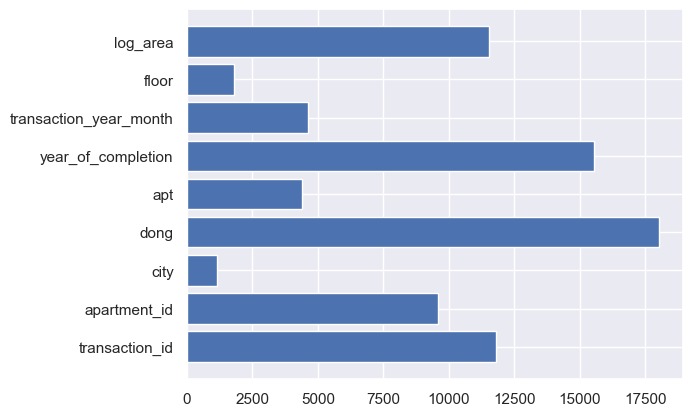

In [36]:
plt.barh(train_X.columns, final_lgb_model.feature_importances_)

In [37]:
final_pred_sub = np.expm1(final_lgb_pred)
final_pred_sub

array([27792.1320666 ,  9017.06445359, 11493.04655481, ...,
       62607.51190698, 38516.50210297, 22295.65953081])

In [38]:
sub = pd.read_csv('test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,27792.132067
1,1198704,9017.064454
2,1222384,11493.046555
3,1179897,112179.064121
4,1223091,44946.381025
...,...,...
5458,1174640,69239.699523
5459,1175575,131123.431002
5460,1157024,62607.511907
5461,1136863,38516.502103


In [39]:
sub_df.to_csv('submission_lgb.csv', index=False)

In [44]:
import joblib

# 최종 학습된 LightGBM 모델 저장
joblib.dump(final_lgb_model, 'final_model.pkl')
joblib.dump(label_encoder_dong, 'label_encoder_dong.pkl')
joblib.dump(label_encoder_apt, 'label_encoder_apt.pkl')


['label_encoder_apt.pkl']

In [41]:
final_pred_sub = np.expm1(final_lgb_pred)
final_pred_sub

array([27792.1320666 ,  9017.06445359, 11493.04655481, ...,
       62607.51190698, 38516.50210297, 22295.65953081])

In [42]:
sub = pd.read_csv('test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,27792.132067
1,1198704,9017.064454
2,1222384,11493.046555
3,1179897,112179.064121
4,1223091,44946.381025
...,...,...
5458,1174640,69239.699523
5459,1175575,131123.431002
5460,1157024,62607.511907
5461,1136863,38516.502103


In [43]:
sub_df.to_csv('submission_lgb.csv', index=False)

In [45]:
# 모든 동의 인코딩 확인
for dong, encoded in zip(label_encoder_dong.classes_, range(len(label_encoder_dong.classes_))):
    print(f"동: {dong}, 인코딩 값: {encoded}")


동: 0, 인코딩 값: 0
동: 1, 인코딩 값: 1
동: 10, 인코딩 값: 2
동: 100, 인코딩 값: 3
동: 101, 인코딩 값: 4
동: 102, 인코딩 값: 5
동: 103, 인코딩 값: 6
동: 104, 인코딩 값: 7
동: 105, 인코딩 값: 8
동: 106, 인코딩 값: 9
동: 107, 인코딩 값: 10
동: 108, 인코딩 값: 11
동: 109, 인코딩 값: 12
동: 11, 인코딩 값: 13
동: 110, 인코딩 값: 14
동: 111, 인코딩 값: 15
동: 112, 인코딩 값: 16
동: 113, 인코딩 값: 17
동: 114, 인코딩 값: 18
동: 115, 인코딩 값: 19
동: 116, 인코딩 값: 20
동: 117, 인코딩 값: 21
동: 118, 인코딩 값: 22
동: 119, 인코딩 값: 23
동: 12, 인코딩 값: 24
동: 120, 인코딩 값: 25
동: 121, 인코딩 값: 26
동: 122, 인코딩 값: 27
동: 123, 인코딩 값: 28
동: 124, 인코딩 값: 29
동: 125, 인코딩 값: 30
동: 126, 인코딩 값: 31
동: 127, 인코딩 값: 32
동: 128, 인코딩 값: 33
동: 129, 인코딩 값: 34
동: 13, 인코딩 값: 35
동: 130, 인코딩 값: 36
동: 131, 인코딩 값: 37
동: 132, 인코딩 값: 38
동: 133, 인코딩 값: 39
동: 134, 인코딩 값: 40
동: 135, 인코딩 값: 41
동: 136, 인코딩 값: 42
동: 137, 인코딩 값: 43
동: 138, 인코딩 값: 44
동: 139, 인코딩 값: 45
동: 14, 인코딩 값: 46
동: 140, 인코딩 값: 47
동: 141, 인코딩 값: 48
동: 142, 인코딩 값: 49
동: 143, 인코딩 값: 50
동: 144, 인코딩 값: 51
동: 145, 인코딩 값: 52
동: 146, 인코딩 값: 53
동: 147, 인코딩 값: 54
동: 148, 인코딩 값: 55
동: 149, 인코딩